# MS025 Preprocess
06/28/2023

In [27]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis/')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS025'
subj_format = ['nlx']
subj_site = ['MSSM']


## Load raw nlx data 


In [5]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [6]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [7]:
seeg_names = [x.lower() for x in seeg_names] 

In [8]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [9]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}')

Unidentified data type in Photodiode


In [10]:
ch_name

['RAglT6',
 'RAglT7',
 'RPVNH4',
 'RPVNH5',
 'LCMiP14',
 'LmOlF6',
 'LmOlF7',
 'RmCmS6',
 'RmCmS7',
 'RHplT6',
 'RHplT7',
 'LaCaS1',
 'RCMiP7',
 'RCMiP6',
 'LHplT10',
 'LHplT11',
 'LCMiP5',
 'LCMiP4',
 'LpTpT1',
 'RaCaS3',
 'RaCaS2',
 'LmCmS4',
 'LmCmS5',
 'LHplT4',
 'LHplT5',
 'RmOlF4',
 'RmOlF5',
 'RaCaS9',
 'RaCaS8',
 'LPVNH6',
 'LPVNH7',
 'LAglT4',
 'LAglT5',
 'LPVNH14',
 'LaCaS12',
 'LCMiP2',
 'LCMiP3',
 'RaCaS4',
 'RaCaS5',
 'LpTpT7',
 'LpTpT6',
 'LHplT3',
 'LHplT2',
 'Photodiode',
 'LAglT9',
 'LAglT8',
 'LmCmS3',
 'LmCmS2',
 'RmOlF3',
 'RmOlF2',
 'RCMiP10',
 'RCMiP11',
 'LCMiP8',
 'LCMiP9',
 'LPVNH1',
 'RmOlF9',
 'RmOlF8',
 'LmCmS9',
 'LmCmS8',
 'LAglT3',
 'LAglT2',
 'LHplT9',
 'LHplT8',
 'LPVNH13',
 'LPVNH12',
 'RAglT1',
 'RPVNH10',
 'RPVNH11',
 'RPVNH3',
 'RPVNH2',
 'LCMiP13',
 'LCMiP12',
 'LmOlF1',
 'RHplT1',
 'RmCmS1',
 'LmCmS10',
 'LmCmS11',
 'RaCaS10',
 'RaCaS11',
 'LaCaS6',
 'LaCaS7',
 'RCMiP1',
 'RPVNH9',
 'RPVNH8',
 'LpTpT9',
 'LpTpT8',
 'LPVNH5',
 'LPVNH4',
 'RCMiP14',

In [11]:
ch_names = list(ch_name)
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
print(probe_names)

['LAglT' 'LCMiP' 'LHplT' 'LPVNH' 'LaCaS' 'LmCmS' 'LmOlF' 'LpTpT'
 'Photodiode' 'RAglT' 'RCMiP' 'RHplT' 'RPVNH' 'RaCaS' 'RmCmS' 'RmOlF']


In [12]:
srs

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,

In [13]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [14]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:   21.1s finished


In [15]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [16]:
mne_data_resampled[0]

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [17]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
#mne_data.add_channels([mne_data_resampled[0]])
mne_data

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [18]:
#make channel names lowercase 
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

## Notch filter line noise

In [19]:

mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    4.3s finished


<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

## Examine photodiode

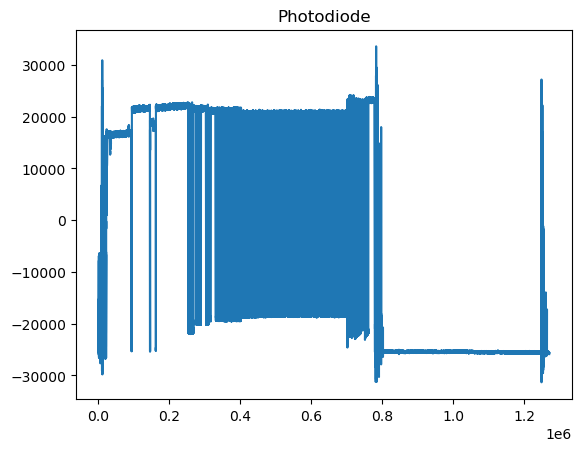

In [20]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('photodiode')
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

Save out photodiode data (after resampling/filtering)

In [21]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='photodiode', overwrite=True)

## Add in anat recon info


In [30]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,notes
0,LaCaS1,A32sg_L,-8.551953,47.560752,20.574440,-7.364096,42.879442,7.816402,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN,NaN
1,LaCaS10,Unknown,-17.348071,64.346899,55.331263,-15.943065,67.827566,42.142829,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
2,LaCaS11,Unknown,-17.747895,65.545910,58.127789,-16.252304,69.749974,44.950649,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-17.747895,65.945580,59.725803,-16.193126,70.554453,46.641912,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32p_L,-9.751424,49.559103,24.968981,-8.600387,46.074869,12.332196,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RPVNH9,mOccG_R,29.431284,-69.942282,-4.993797,29.084658,-86.459783,9.976051,White,Right Cerebral White Matter,Area hOc4lp,R Middle Occipital Gyrus,R LOcC,Right superior middle occipital gyrus D,NaN,NaN
168,uLAglT,rHipp_L,-16.148600,10.391424,-14.981390,-16.594453,-3.626931,-23.761121,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,Left amygdala inferior,NaN
169,uLmOlF,A11m_L,-8.951776,61.549208,-4.594294,-7.639574,50.840300,-25.038950,Gray,Left MOrG medial orbital gyrus,Area Fo1,L Superior Orbital Gyrus,L OrG,Left frontal orbital 2 B,NaN,NaN
170,uRAglT,rHipp_R,15.037636,10.391424,-14.182383,17.162481,-3.723941,-23.243948,Gray,Right Amygdala,Amygdala (LB),R ParaHippocampal Gyrus,R Hipp,Right amygdala inferior,NaN,NaN


In [31]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['photodiode']


In [32]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)




In [33]:
unmatched_names

['ulaglt', 'urmolf', 'uraglt', 'ulmolf']

In [34]:
unmatched_seeg

[]

In [35]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 92 left sEEG and 76 right sEEG electrodes
We have a total of 168 sEEG electrodes


In [36]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'photodiode':'stim'}
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [37]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [ ]:
bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [ ]:
bads

In [ ]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [ ]:
probe_names

In [ ]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [ ]:
probe_ch_counts

In [ ]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/5)
fig.fake_keypress('a')

In [ ]:
mne_data.info['bads']

In [38]:
##save info in SWB_electrode_info spreadsheet!
bad_ch = ['lmcms7',
 'racas7',
 'racas9',
 'laglt5',
 'lacas12',
 'lhplt2',
 'lmcms2',
 'lcmip8',
 'rmolf8',
 'lmcms8',
 'rmolf9',
 'racas10',
 'lmcms6',
 'lmcms12',
 'laglt1',
 'lhplt1',
 'lmcms1']

In [39]:
mne_data.info['bads'] = bad_ch

In [40]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 17 items (lmcms7, racas7, racas9, laglt5, lacas12, lhplt2, ...)
 ch_names: raglt6, raglt7, rpvnh4, rpvnh5, lcmip14, lmolf6, lmolf7, rmcms6, ...
 chs: 168 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 168 items (168 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 169
 projs: []
 sfreq: 500.0 Hz
>

### Rereference data to wm electrodes

In [41]:
unmatched_seeg = [] #need this to run script, also need site = 'MSSM' because davis site specificity hasn't been implemented yet 

In [42]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [43]:
oob_channels

['lacas10',
 'lacas11',
 'lacas12',
 'lacas7',
 'lacas8',
 'lacas9',
 'lhplt12',
 'lmcms10',
 'lmcms11',
 'lmcms12',
 'lpvnh14',
 'racas11',
 'racas12',
 'rmcms10',
 'rmcms9',
 'rpvnh12']

In [44]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [45]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas10',
 'lacas11',
 'lacas12',
 'lacas7',
 'lacas8',
 'lacas9',
 'laglt1',
 'laglt5',
 'lcmip8',
 'lhplt1',
 'lhplt12',
 'lhplt2',
 'lmcms1',
 'lmcms10',
 'lmcms11',
 'lmcms12',
 'lmcms2',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'lpvnh14',
 'racas10',
 'racas11',
 'racas12',
 'racas7',
 'racas9',
 'rmcms10',
 'rmcms9',
 'rmolf8',
 'rmolf9',
 'rpvnh12']

In [46]:
mne_data.save(f'{neural_dir}{subj_id}/lfp_data.fif',overwrite=True)

In [47]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [48]:
mne_data_reref

<RawArray | 131 x 1269504 (2539.0 s), ~1.24 GB, data loaded>

In [50]:
mne_data_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)